# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: 31
* Students: Dilara Günay, Derin Sinan Bursa, Othman Benchekroun, Sinan Gökçe
* Dataset: IMDb Films and Crew

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [14]:
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

In [15]:
movies = pd.read_csv('data/tmdb_5000_credits.csv')
movies = movies[movies.cast != '[]']

**Explanation**: In the function below, we only keep the relevant information (<i>movie_id</i> and <i>cast</i> providing us with information on each person). Moreover, we add an important new column: the list of all people playing in a movie, which will be necessary for future steps.

In [16]:
def flatten():
    movies.drop(['title', 'crew'], axis=1, inplace=True)
    movies['cast_id'] = movies['cast'].apply(lambda row: list(set(pd.read_json(row)['id'])))

In [17]:
flatten()
movies.head()

,movie_id,cast,cast_id
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[397312, 1180936, 1145098, 1186027, 103259, 30..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[2440, 2441, 2449, 2450, 2452, 1430, 939, 2603..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[1168129, 1599239, 1599241, 48393, 1599245, 15..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[21505, 53252, 1172491, 77335, 535, 1574936, 5..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[1721985, 62082, 17287, 1721992, 17419, 6416, ..."


**Explanation:** Given the size of our dataset, we decided to keep only the cast members that played in at least 5 movies. Thus, we create a list containing the ids of these actors in order to filter the rest out from <i>cast_id</i>. After this, we generate the list of edges corresponding to our problem: all the actors which played in the same movie.  

In [18]:
discount = movies['cast_id'].apply(pd.Series).stack().value_counts()
discount = list(discount[discount > 4].index.astype(int))
discount[:10]

[2231, 380, 62, 1892, 192, 884, 3896, 887, 85, 2963]

In [19]:
movies['cast_id'] = movies['cast_id'].apply(lambda x: [y for y in x if y in discount])
movies['edges'] = movies['cast_id'].apply(lambda x: list(itertools.combinations(x, 2)))
edges = list(movies['edges'].apply(pd.Series).stack())
edges[0:5]

edges_df = pd.DataFrame(edges)
edges_df.to_csv("data/edges.csv")

**Explanation:** We noticed that some movies didn't have any ids in the <i>cast_id</i> anymore, meaning that all the actors that played in them played in less than $5$ movies. Thus, we simply decided to drop.

In [7]:
discarded_movies = set()

for idx, movie in movies.iterrows():
    if len(movie['edges']) == 0:
        discarded_movies.add(movie['movie_id'])

print(len(discarded_movies))        

627


In [8]:
movies = movies[~movies['movie_id'].isin(discarded_movies)]
movies.head()

,movie_id,cast,cast_id,edges
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[30485, 236696, 98215, 42286, 68278, 65731, 42...","[(30485, 236696), (30485, 98215), (30485, 4228..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[2440, 2441, 2449, 2452, 939, 1709, 1711, 1714...","[(2440, 2441), (2440, 2449), (2440, 2452), (24..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[139549, 17064, 543530, 27319, 121529, 5309, 2...","[(139549, 17064), (139549, 543530), (139549, 2..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[21505, 53252, 77335, 535, 1574936, 539, 15805...","[(21505, 53252), (21505, 77335), (21505, 535),..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[17287, 17419, 2206, 2983, 5293, 21044, 57675,...","[(17287, 17419), (17287, 2206), (17287, 2983),..."


**Explanation:** After creating the edge list, we create the features that will be useful later on. We decided to keep the <i>gender</i> and the <i>movies</i> an actor played in as the main features. However, we may enrich this list in the future.

In [9]:
frames = pd.DataFrame()
new_df = pd.DataFrame()

for idx, film in movies.iterrows():
    cast_df = pd.DataFrame(eval(movies['cast'][idx]))
    cast_df['movies'] = idx
    cast_df = cast_df.drop(['character','order','cast_id', 'credit_id'],axis = 1)  
    
    frames = [new_df, cast_df]
    new_df = pd.concat(frames, join = 'outer', ignore_index=True)

In [10]:
nodes_df = new_df['movies'].groupby([new_df.gender, new_df.id, new_df.name]).apply(list).reset_index()
nodes_df = nodes_df[nodes_df.id.isin(discount)]
nodes_df.head()

,gender,id,name,movies
10,0,334,Omar Benson Miller,"[103, 1094, 1141, 1190, 1233, 1325, 2043, 3112]"
14,0,424,Dallas Roberts,"[1019, 1684, 1844, 2574, 3434, 3571, 3847]"
21,0,652,Paul Freeman,"[1460, 1524, 2085, 2360, 2437, 2471, 2645]"
26,0,693,Roshan Seth,"[83, 523, 1404, 1697, 2024, 4588]"
35,0,939,David Schofield,"[1, 12, 274, 360, 1063, 1239]"


In [11]:
features = nodes_df.set_index('id').drop('name', axis=1)
features.head()

,gender,movies
id,,
334,0,"[103, 1094, 1141, 1190, 1233, 1325, 2043, 3112]"
424,0,"[1019, 1684, 1844, 2574, 3434, 3571, 3847]"
652,0,"[1460, 1524, 2085, 2360, 2437, 2471, 2645]"
693,0,"[83, 523, 1404, 1697, 2024, 4588]"
939,0,"[1, 12, 274, 360, 1063, 1239]"


### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

**Explanation:** As we need a way to keep track of the ids of the cast members, we first create a DataFrame in order to construct our adjacency matrix. The <i>discount</i> list (exhaustive list of the nodes) will be used as a mapping between the nodes and the adjacency matrix; meaning their index in the matrix is simply their index in the <i>discount</i> list.

After this, we simply convert the adjacency matrix to a Numpy array and normalize it.

In [12]:
adj = pd.DataFrame(np.zeros(shape=(len(discount),len(discount))), columns=discount, index=discount)
for e1, e2 in edges:
    if e1 in discount and e2 in discount:
        adj.at[e1, e2] += 1
        adj.at[e2, e1] += 1
    else:
        edges.remove((e1,e2))
adj.head()

,2231,380,62,1892,192,884,3896,887,85,2963,...,15565,118593,41746,59019,208519,66288,3033,17187,51998,21318
2231,0.0,2.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
380,2.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,4.0,1.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,1.0,2.0,1.0,0.0,0.0,4.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
adjacency = adj.values
adj_max = adjacency.max()
adjacency = np.vectorize(lambda x: x/adj_max)(adjacency)

adjacency_df = pd.DataFrame(adjacency)
adjacency_df.to_csv("data/adjacency.csv")

In [14]:
n_nodes = len(discount)
n_nodes

3766

## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

Text(0.5, 1.05, 'adjacency matrix')

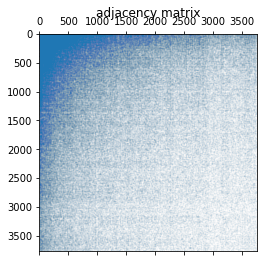

In [15]:
plt.spy(adjacency, markersize=0.005)
plt.title('adjacency matrix')

**Explanation:** As we can see in this plot, the first actors are much more connected then the last actors. This results could be explained by the fact that our adjacency matrix is in a decreasing order of number of movies played. So the first rows contain the actors that played in most movies and the last rows contain the actors that played in the least amount of movies. As such, it is expected that the actors that played in the most are statistically the ones that will be the most connected to other actors.

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [16]:
L_max = n_nodes*(n_nodes-1)/2
print("We have that L_max is equal to {}".format(L_max))

We have that L_max is equal to 7089495.0


In [17]:
print("The number of links in our network is {:.2f} on average".format(L_max / len(edges)))

The number of links in our network is 34.35 on average


In [18]:
print("When trying to determine the big-O notation, we have {:.2f}, which is explained below".format(n_nodes * math.sqrt(n_nodes)))

When trying to determine the big-O notation, we have 231110.92, which is explained below


**Answer:** We have that the network is not fully connected, yet not sparse. Indeed, we have that $L=O(n*\sqrt{n})$ .

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**Explanation:** To make a matrix symmetric, we sum the original matrix with its transpose and divide the result by 2.

In [19]:
adjacency = (adjacency + adjacency.T)/2

### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [20]:
np.save("data/adj.npy", adjacency)
features.to_csv("data/features.csv")

### Question 4

Are the edges of your graph weighted?

**Answer:** Yes, the edges of the graph are weighted and the weights correspond to the number of movies where actors played together.

### Question 5

What is the degree distibution of your network? 

In [21]:
degree = np.count_nonzero(adjacency, axis=1)

assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

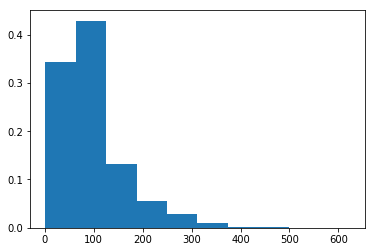

In [22]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

What is the average degree?

In [23]:
print("The average degree of the graph is {:.2f}".format(np.sum(degree)/n_nodes))

The average degree of the graph is 98.52


### Question 6

Comment on the degree distribution of your network.

**Answer:** The average degree ($\sim99$) of the graph seems large, but it is not unexpected if we follow the rule of thumb. Indeed, in average, there are $8$ actors in a movie, and each actor plays in $10$ movies. When looking at the degree distribution itself, we see that it looks like a skewed normal distribution, allowing us to use the properties – and interpretation – of the Normal distribution but introducing a skew parameter to account for the shape difference.

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

**Explanation:** In order to determine if our network is connected or not, we start from the index zero of the adjacency matrix and store the indices of the connected nodes step by step into a set called <i>visited</i>. Then, we compare <i>n_nodes</i> with the number of elements in the <i>visited</i> set to see if the whole graph is connected or not.

In [24]:
def connected_graph(adjacency):
    visited, queue = set(), [0] # store the indices of columns/rows
    while queue:
        index = queue.pop(0)
        if index not in visited:
            visited.add(index)
            actor_connected_to = set(np.nonzero(adjacency[index])[0])
            queue.extend(actor_connected_to - visited)
            
    if len(visited) == len(adjacency):
        connected = True
    else:
        connected = False
    
    return connected

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [25]:
if(connected_graph(adjacency)):
    print('Our graph is connected')
else:
    print('Our graph is not connected')

Our graph is connected


### Question 8

Write a function that extracts the connected components of a graph.

**Explanation:** First, we find the connected nodes starting from the index zero of the adjacency matrix and store the first connected component in a list called <i>component_list</i>. Meanwhile, we store the indices of the unconnected nodes in a set called <i>not_visited</i> and loop again to add a new connected component into <i>component_list</i> starting with the indices in <i>not_visited</i> until <i>not_visited</i> is empty. Finally, we return the list of all connected components.

In [26]:
def find_components(adjacency):
    not_visited = []
    for i in range(len(adjacency)):
        not_visited.append(i)
    #Before starting the while loop, not_visited contains all the nodes (row indices in the adjacency matrix)
    
    component_list = list() #Used to store the components
    while not_visited:
        queue = [not_visited[0]]
        visited = set()
        while queue:
            index = queue.pop(0)
            if index not in visited:
                visited.add(index)
                actor_connected_to = set(np.nonzero(adjacency[index])[0])
                queue.extend(actor_connected_to - set(visited))
                
        not_visited = list(set(not_visited) - visited)
        component_list.append(list(visited)) 
    
    components = []
    for idx, value in enumerate(component_list):
        comp_adj = np.take(adjacency, component_list[idx], axis = 0)
        comp_adj = np.take(comp_adj, component_list[idx], axis = 1)
        components.append(comp_adj)
    return components


How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [27]:
components_adjacency = find_components(adjacency)
print('Our network is composed of', len(components_adjacency), 'connected components.\n')
print('The size of the largest connected component is ', len(components_adjacency[0]))

Our network is composed of 1 connected components.

The size of the largest connected component is  3766


### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

**Explanation:** This function takes the adjacency matrix and the index of a starting node as inputs. As we try to determine the <i>hop_distance</i>, we tag the source node as 0 and all the nodes it is directly connected to are tagged as 1. Then, all the nodes connected to the one with tag 1 are tagged with 2, and so on until all the connected graph is tagged. The unconnected nodes are tagged as <i>inf</i> since there is no way to get to them starting from any point of the connected graph.

In [28]:
def compute_shortest_path_lengths(adjacency, source):
    
    shortest_path_lengths = np.full(len(adjacency), np.inf, dtype=float)
    visited, queue = set(), [source]
    hop_distance = 0
    queue2 = list()
    while queue:
        index = queue.pop(0)
        if index not in visited:
            visited.add(index)
            shortest_path_lengths[index] = hop_distance
            actor_connected_to = set(np.nonzero(adjacency[index])[0])
            queue2.extend(actor_connected_to - visited)
        if not queue:
            hop_distance = hop_distance + 1
            queue.extend(queue2)
            queue2 = list()    
    return shortest_path_lengths

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

**Explanation:** We have randomly selected $1000$ indices/nodes from the adjacency matrix and created a new adjacency matrix (graph) with these $1000$ nodes. Then, we check if this new adjacency matrix is a connected graph or not. In case it is not connected, we look for the connected components of this new graph and calculate the diameter of the largest component.

In [29]:
sample_size = 1000
random_source_list = np.random.randint(0,n_nodes,size=sample_size)

adjacency_random = np.take(adjacency, random_source_list, axis=0)
adjacency_random = np.take(adjacency_random, random_source_list, axis=1)

print()

print('When randomly downsampling our actors data, we find', len(find_components(adjacency_random)), 'connected components in our new graph')

max_length_list = []

for source in range(sample_size):
    max_length_list.append(max(compute_shortest_path_lengths(adjacency_random, source)))
max_length = max(max_length_list)   

if(connected_graph(adjacency_random)):
    print('Our randomly downsampled network is connected')
else:
    print('Our randomly downsampled network is not connected')

print('The diameter of the whole randomly downsampled data is:', max_length)

components = find_components(adjacency_random)   
number_of_components = len(components)    
if number_of_components > 1: #If the downsampled graph is not connected
    component_length_list = []
    for i in range(number_of_components):
        component_length_list.append(len(components[i]))
    
    length_array = np.array(component_length_list)
    index_largest_component = np.argmax(length_array)
    
    adjacency_random_connected = components[index_largest_component]
    
    max_length_list = []
    for source in range(len(adjacency_random_connected)):
        max_length_list.append(max(compute_shortest_path_lengths(adjacency_random_connected, source)))
    max_length = max(max_length_list)   

    print('The diameter of the largest connected component of our randomly downsampled network is: ', max_length)


When randomly downsampling our actors data, we find 2 connected components in our new graph
Our randomly downsampled network is not connected
The diameter of the whole randomly downsampled data is: inf
The diameter of the largest connected component of our randomly downsampled network is:  6.0


### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

**Explanation:** In this segment, we try to find the number of paths of a given length. We form a new unweighted adjacency matrix by assigning $1$ if two nodes are connected and $0$ if the nodes are not connected (which we call <i>adjacency_non_weighted</i>). Then, according to the theorem seen during the class about <b>"GraphTheoryBasics"</b>, we compute the number of paths between two nodes by multiplying the adjacency matrix <i>n</i> times with itself (where <i>n</i> is the desired path length). Therefore we obtain a matrix where the value at index <i>i,j</i> is the number of paths with length <i>n</i> that are connecting nodes <i>i</i> and <i>j</i>. In our case, we have tha <i>i</i> is the source while <i>j</i> the target.

In [30]:
def compute_paths(adjacency, source, target, length):
    
    adjacency_non_weighted = adjacency.copy()
    adjacency_non_weighted[adjacency_non_weighted > 0] = 1
    adjacency_non_weighted = np.asmatrix(adjacency_non_weighted)
    
    matrix_path_lengths = adjacency_non_weighted**length
    n_paths = matrix_path_lengths[source, target]
  
    return n_paths

Test your function on 5 pairs of nodes, with different lengths.

In [31]:
print(compute_paths(adjacency, 0, 10, 1))
print(compute_paths(adjacency, 0, 10, 2))
print(compute_paths(adjacency, 0, 10, 3))
print(compute_paths(adjacency, 23, 67, 2))
print(compute_paths(adjacency, 15, 93, 4))

0.0
75.0
13007.0
54.0
722156.0


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

**Explanation:** In order to find out how many paths of length $3$ there are, we start by taking the adjacency matrix (<i>adjacency_non_weighted</i> as explained above). As seen in the previous question, the paths with length $3$ can be found by multiplying the adjacency matrix $3$ times with itself. As our matrix is symmetric, it contains the same path information twice (the number of paths between <i>i</i> and <i>j</i> is the same for <i>j</i> and <i>i</i>). Thus, we remove all values below the diagonal in order to have an upper triangular matrix and take the sum of the values in the matrix – which gives us the total number of paths with length $3$.

In our case we decided to keep the diagonal values. These values give us the number of path with length $3$ that connects the same actors.

In [32]:
adjacency_non_weighted = adjacency
adjacency_non_weighted[adjacency_non_weighted > 0] = 1
adjacency_non_weighted = np.asmatrix(adjacency_non_weighted)
matrix_path_lengths = adjacency_non_weighted**3
upper_tri = np.triu(matrix_path_lengths, 0)
np.sum(upper_tri)

3759037470.0

### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

**Explanation**: This algorithm simply roams through the list of neighbors of <i>node</i> in order to determine any links between them. The <i>visited</i> set allows us to keep track of the nodes that were already taken into account (which is why we keep the $2$ at the beginning of the final formula).

In [33]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    
    visited = set()
    neighbors = set(np.nonzero(adjacency[node])[0])
    
    if len(neighbors) == 0 or len(neighbors) == 1:
        return 0
    
    links = 0
    
    for u in neighbors:
        visited.add(u)
        nonzero = set(np.nonzero(adjacency[u])[0]) - set([node])
        for v in (neighbors - visited):
            if v in nonzero:
                links += 1
    
    clustering_coefficient = (2*links)/(len(neighbors)*(len(neighbors)-1))
    
    return clustering_coefficient

In [34]:
compute_clustering_coefficient(adjacency, 3669)

0.2905525846702317

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [35]:
avg_coefficient = 0

for node in range(n_nodes):
    avg_coefficient += compute_clustering_coefficient(adjacency, node)
    
avg_coefficient = avg_coefficient/n_nodes
print(avg_coefficient)

0.22305771147081796


**Answer:** We have that the average clustering coefficient is around $0.22$.